In [2]:
# Importing Numpy & Pandas for data processing, wrangling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
# Import evaluation metric libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Word Cloud library
from wordcloud import WordCloud, STOPWORDS

# Library used for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import model selection libraries
from sklearn.model_selection import train_test_split

# Library used for ML Model implementation
from sklearn.naive_bayes import MultinomialNB

# Importing the Pipeline class from scikit-learn
from sklearn.pipeline import Pipeline

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load Dataset from github repository
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')

In [12]:
# Dataset Rows & Columns count
# Checking number of rows and columns of the dataset using shape
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1])

Number of rows are:  5572
Number of columns are:  5


In [14]:
# Dataset Info
# Checking information about the dataset using info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [16]:
# Dataset Duplicate Value Count
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 403


In [18]:
# Missing Values/Null Values Count
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Obervation

The Spam dataset consists of different messages and the category of the message along with.
There are 5572 rows and 5 columns provided in the data.
403 duplicate rows are present in the dataset.
No Null values exist in v1 & v2 column, but lots of null values present in unnamed 2,3,4 columns (will drop those 3 columns later).

In [21]:
# Dataset Columns
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [23]:
# Dataset Describe (all columns included)
df.describe(include= 'all').round(2)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [25]:
# Check Unique Values for each variable using a for loop.
for i in df.columns.tolist():
  print("No. of unique values in",i,"is",df[i].nunique())

No. of unique values in v1 is 2
No. of unique values in v2 is 5169
No. of unique values in Unnamed: 2 is 43
No. of unique values in Unnamed: 3 is 10
No. of unique values in Unnamed: 4 is 5


In [27]:
# Change the v1 & v2 columns as Category and Message
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)

In [29]:
# Removing the all unnamed columns (its include much number of missing values)
df.drop(columns={'Unnamed: 2','Unnamed: 3','Unnamed: 4'}, inplace=True)
     

In [31]:
# Create a binary 'Spam' column: 1 for 'spam' and 0 for 'ham', based on the 'Category' column.
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [33]:
# Updated new dataset
df.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables

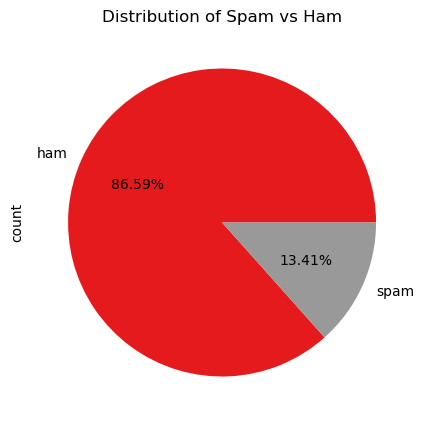

In [39]:
# Chart - 1 Pie Chart Visualization Code For Distribution of Spam vs Ham Messages
spread = df['Category'].value_counts()
plt.rcParams['figure.figsize'] = (5,5)

# Set Labels
spread.plot(kind = 'pie', autopct='%1.2f%%', cmap='Set1')
plt.title(f'Distribution of Spam vs Ham')

# Display the Chart
plt.show()
     

From the above chart, we got to know that the dataset contain 13.41% of spam messages and 86.59% of ham messages.

In [42]:
# Splitting Spam Messages
df_spam = df[df['Category']=='spam'].copy()

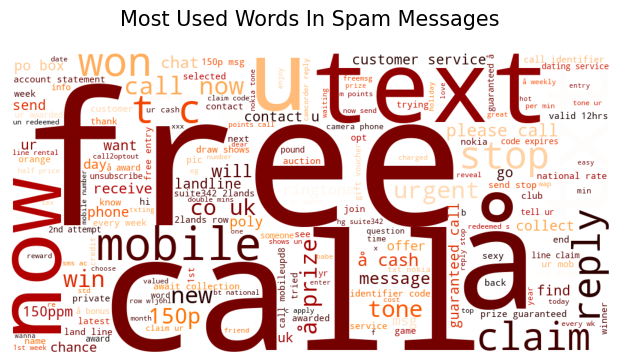

In [44]:
# Chart - 2 WordCloud Plot Visualization Code For Most Used Words in Spam Messages
# Create a String to Store All The Words
comment_words = ''

# Remove The Stopwords
stopwords = set(STOPWORDS)

# Iterate Through The Column
for val in df_spam.Message:

    # Typecaste Each Val to String
    val = str(val)

    # Split The Value
    tokens = val.split()

    # Converts Each Token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

# Set Parameters
wordcloud = WordCloud(width = 1000, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,
                max_words = 1000,
                colormap = 'gist_heat_r').generate(comment_words)

# Set Labels
plt.figure(figsize = (6,6), facecolor = None)
plt.title('Most Used Words In Spam Messages', fontsize = 15, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Display Chart
plt.show()
     

## Feature Engineering

In [48]:
# Splitting the data to train and test
X_train,X_test,y_train,y_test=train_test_split(df.Message,df.Spam,test_size=0.25)
     

### ML Model Implementation

In [52]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    '''The function will take model, x train, x test, y train, y test
    and then it will fit the model, then make predictions on the trained model,
    it will then print roc-auc score of train and test, then plot the roc, auc curve,
    print confusion matrix for train and test, then print classification report for train and test,
    then plot the feature importances if the model has feature importances,
    and finally it will return the following scores as a list:
    recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test
    '''

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")


    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

In [54]:
# ML Model - 1 Implementation
# Create a machine learning pipeline using scikit-learn, combining text vectorization (CountVectorizer)
# and a Multinomial Naive Bayes classifier for email spam detection.
clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Text data transformation
    ('nb', MultinomialNB())  # Step 2: Classification using Naive Bayes
])

# Model is trained (fit) and predicted in the evaluate model
     


Train ROC AUC: 0.9819737095472404
Test ROC AUC: 0.9707179573539908


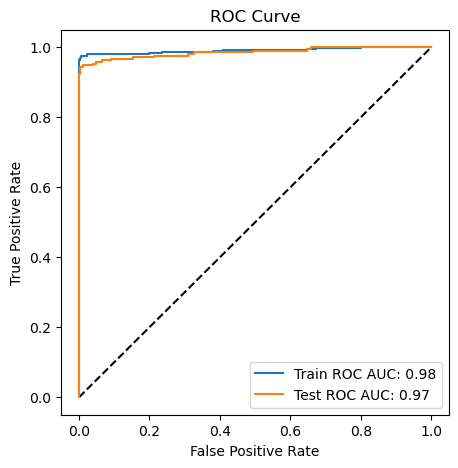


Confusion Matrix:


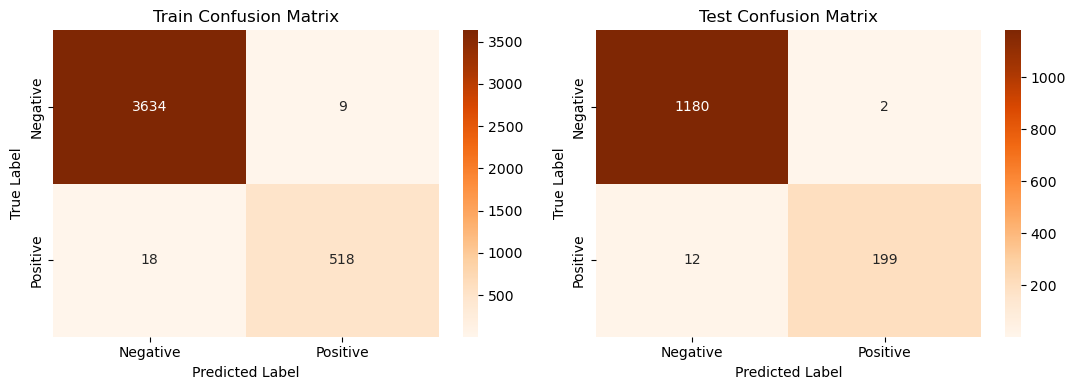


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.995071 | 0.99753  |   0.996299 | 3643        |
| 1            |    0.982922 | 0.966418 |   0.9746   |  536        |
| accuracy     |    0.993539 | 0.993539 |   0.993539 |    0.993539 |
| macro avg    |    0.988997 | 0.981974 |   0.98545  | 4179        |
| weighted avg |    0.993513 | 0.993539 |   0.993516 | 4179        |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.989933 | 0.998308 |   0.994103 | 1182       |
| 1            |    0.99005  | 0.943128 |   0.966019 |  211       |
| accuracy     |    0.98995  | 0.98995  |   0.98995  |    0.98995 |
| macro avg    |    0.989991 | 0.970718 |   0.980061 | 1393       |
| weighted avg |    0.989951 | 0.98995  |   0.9898

In [56]:
# Visualizing evaluation Metric Score chart
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)

After carefully considering the potential consequences of false positives and false negatives in the context of our business objectives, I have selected recall as the primary evaluation metric for our email spam detection model. Its gives 98.49% accuracy for recall test set.

## Email Spam Detection System

In [60]:
# Defining a function for the Email Spam Detection System
def detect_spam(email_text):
    # Load the trained classifier (clf) here
    # Replace the comment with your code to load the classifier model

    # Make a prediction using the loaded classifier
    prediction = clf.predict([email_text])

    if prediction == 0:
        return "This is a Ham Email!"
    else:
        return "This is a Spam Email!"


In [62]:
# Example of how to use the function
sample_email = 'Free Tickets for IPL'
result = detect_spam(sample_email)
print(result)

This is a Spam Email!
